In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import load_model
import shutil

In [2]:
dt="UTKFace"

In [3]:
files=os.listdir(dt)

In [6]:
# Function to load and preprocess images
def load_utkface_images(dt):
    images = []
    ages = []
    genders = []
    filenames = []

    for filename in os.listdir(dt):
        try:
            age = int(filename.split('_')[0])
            gender = int(filename.split('_')[1])
            image_path = os.path.join(dt, filename)
            
            # Load and preprocess the image
            image = cv2.imread(image_path)
            if image is None:
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            
            # Append the image and corresponding age and gender to lists
            images.append(image)
            ages.append(age)
            genders.append(gender)
            filenames.append(filename)
        except IndexError:
            print(f"Skipping file {filename} due to unexpected format")
    
    images = np.array(images)
    ages = np.array(ages)
    genders = np.array(genders)
    return images, ages, genders, filenames

In [7]:
# Load and filter images by age range
images, ages, genders, filenames = load_utkface_images(dt)
age_filter = (ages >= 20) & (ages <= 30)
filtered_images = images[age_filter]
filtered_genders = genders[age_filter]
filtered_filenames = np.array(filenames)[age_filter]

print(f"Filtered images: {filtered_images.shape[0]}")
print(f"Filtered genders: {filtered_genders.shape[0]}")

Filtered images: 8068
Filtered genders: 8068


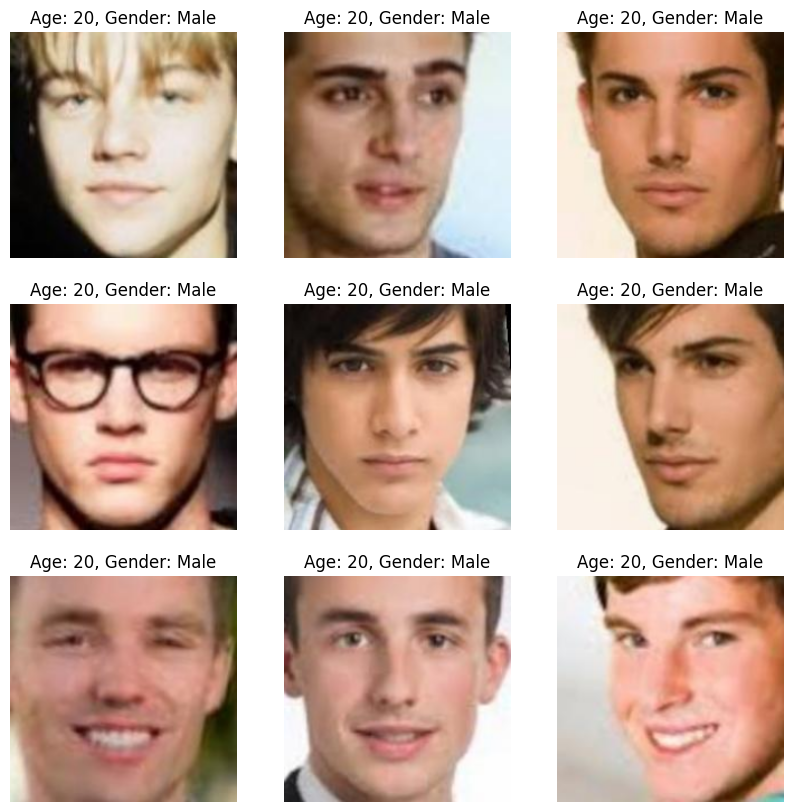

In [8]:
# Display a few sample images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(filtered_images[i])
    plt.title(f"Age: {ages[age_filter][i]}, Gender: {'Male' if filtered_genders[i] == 0 else 'Female'}")
    plt.axis('off')
plt.show()

In [9]:
# Directories for labeled images
long_hair_dir = 'labeled_images/long'
short_hair_dir = 'labeled_images/short'

In [10]:
os.makedirs(long_hair_dir, exist_ok=True)
os.makedirs(short_hair_dir, exist_ok=True)

In [12]:
def label_image(image_path, label):
    if label == 'long':
        shutil.copy(image_path, os.path.join(long_hair_dir, os.path.basename(image_path)))
    elif label == 'short':
        shutil.copy(image_path, os.path.join(short_hair_dir, os.path.basename(image_path)))
        
# Iterate over images and display them for labeling
for dirname, _, filenames in os.walk(dt):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        image = cv2.imread(file_path)
        
        if image is not None:
            cv2.imshow('Label Hair Length', image)
            key = cv2.waitKey(0) & 0xFF
            
            if key == ord('l'):  # Press 'l' for long hair
                label_image(file_path, 'long')
                print(f"Labeled {filename} as long hair")
            elif key == ord('s'):  # Press 's' for short hair
                label_image(file_path, 'short')
                print(f"Labeled {filename} as short hair")
            elif key == ord('q'):  # Press 'q' to quit
                print("Quitting...")
                break

cv2.destroyAllWindows()

Labeled 100_0_0_20170112213500903.jpg.chip.jpg as short hair
Labeled 100_0_0_20170112215240346.jpg.chip.jpg as short hair
Labeled 100_1_0_20170110183726390.jpg.chip.jpg as long hair
Labeled 100_1_0_20170112213001988.jpg.chip.jpg as short hair
Labeled 100_1_0_20170112213303693.jpg.chip.jpg as short hair
Labeled 100_1_0_20170112215032192.jpg.chip.jpg as short hair
Labeled 100_1_0_20170117195420803.jpg.chip.jpg as short hair
Labeled 100_1_0_20170119212053665.jpg.chip.jpg as short hair
Labeled 100_1_2_20170105174847679.jpg.chip.jpg as short hair
Labeled 100_1_2_20170112213615815.jpg.chip.jpg as short hair
Labeled 100_1_2_20170112222336458.jpg.chip.jpg as short hair
Labeled 101_0_0_20170112213500903.jpg.chip.jpg as short hair
Labeled 101_1_2_20170105174739309.jpg.chip.jpg as short hair
Labeled 103_0_2_20170112213001988.jpg.chip.jpg as short hair
Labeled 105_0_0_20170112213001988.jpg.chip.jpg as short hair
Labeled 105_1_0_20170112213001988.jpg.chip.jpg as short hair
Labeled 105_1_0_201701122

In [ ]:
Train Hair Length Classification Model

In [13]:
# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [14]:
# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification for hair length

In [15]:
# Define the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,560,769 (105.14 MB)

 Trainable params: 12,846,081 (49.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [16]:
# Prepare the data generators
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    'labeled_images',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    'labeled_images',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 339 images belonging to 2 classes.
Found 84 images belonging to 2 classes.


In [17]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)

# Save the trained model
model.save('hair_length_classification_model.h5')

Epoch 1/10


C:\Users\SARATHLAL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 103s 9s/step - accuracy: 0.4699 - loss: 6.8090 - val_accuracy: 0.3906 - val_loss: 0.8609
Epoch 2/10
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1:08 8s/step - accuracy: 0.5938 - loss: 0.6594

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 558ms/step - accuracy: 0.5938 - loss: 0.6594 - val_accuracy: 0.5000 - val_loss: 0.8897
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 102s 10s/step - accuracy: 0.5601 - loss: 0.7552 - val_accuracy: 0.4219 - val_loss: 0.6996
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 493ms/step - accuracy: 0.5789 - loss: 0.6025 - val_accuracy: 0.8000 - val_loss: 0.5149
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 107s 10s/step - accuracy: 0.7222 - loss: 0.5316 - val_accuracy: 0.8750 - val_loss: 0.4137
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 508ms/step - accuracy: 0.7812 - loss: 0.4925 - val_accuracy: 0.6500 - val_loss: 0.5480
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 85s 8s/step - accuracy: 0.7758 - loss: 0.4737 - val_accuracy: 0.7656 - val_loss: 0.4481
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 529ms/step - accuracy: 0.7812 - loss: 0.5154 - val_accuracy: 0.8500 - val_loss: 0.3009
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 85s 8s/step - accuracy: 0.7600 - loss: 0.4600 - val_accuracy: 0.7969 - val_

In [1]:
Training a Gender Classifier

In [20]:
# Load pre-trained hair length classifier
hair_length_model = load_model('hair_length_classification_model.h5')

In [21]:
# Normalize images
images = images / 255.0

MemoryError: Unable to allocate 26.6 GiB for an array with shape (23708, 224, 224, 3) and data type float64

In [22]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, genders, test_size=0.2, random_state=42)


In [23]:
# Train the gender classifier
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
gender_predictions = Dense(1, activation='sigmoid')(x)

gender_model = Model(inputs=base_model.input, outputs=gender_predictions)
for layer in base_model.layers:
    layer.trainable = False

gender_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gender_model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,560,769 (105.14 MB)

 Trainable params: 12,846,081 (49.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [24]:
# Use ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

gender_history = gender_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    validation_data=(X_val, y_val),
    validation_steps=len(X_val) // 32,
    epochs=10
)

Epoch 1/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 4444s 7s/step - accuracy: 0.8038 - loss: 4.5616 - val_accuracy: 0.8912 - val_loss: 0.2593
Epoch 2/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 773s 1s/step - accuracy: 0.8750 - loss: 0.2653 - val_accuracy: 0.8952 - val_loss: 0.2537
Epoch 3/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 3843s 6s/step - accuracy: 0.8979 - loss: 0.2486 - val_accuracy: 0.9013 - val_loss: 0.2348
Epoch 4/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 756s 1s/step - accuracy: 1.0000 - loss: 0.0892 - val_accuracy: 0.9015 - val_loss: 0.2351
Epoch 5/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 3788s 6s/step - accuracy: 0.9103 - loss: 0.2171 - val_accuracy: 0.9000 - val_loss: 0.2281
Epoch 6/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 738s 1s/step - accuracy: 0.9375 - loss: 0.2540 - val_accuracy: 0.9003 - val_loss: 0.2278
Epoch 7/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 3764s 6s/step - accuracy: 0.9120 - loss: 0.2043 - val_accuracy: 0.9013 - val_loss: 0.2301
Epoch 8/10
592/592 ━━━━━━━━━━━━━━━━━━━━ 725s 1s/step - accuracy: 0.9062 - loss: 0.1073 - val_

In [25]:
# Save the gender classifier model
gender_model.save('gender_classifier_model.h5')

In [ ]:
Custom Prediction Logic

In [27]:
from tensorflow.keras.models import load_model

In [56]:
# Load the trained models
hair_length_model = load_model('hair_length_classification_model.h5')
gender_model = load_model('gender_classifier_model.h5')

In [60]:

# Custom prediction function with enhanced error handling
def custom_predict(image_path, gender_model, hair_length_model):
    # Check if the image path exists
    if not os.path.exists(image_path):
        raise ValueError(f"Image path {image_path} does not exist. Please check the path and try again.")
    
    # Attempt to read the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image at path {image_path} could not be loaded. Please check the path and try again.")
    
    # Preprocess the image
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    
    # Extract age from the filename
    try:
        age = int(os.path.basename(image_path).split('_')[0])
    except ValueError:
        raise ValueError(f"Failed to extract age from the image filename {os.path.basename(image_path)}")
    
    # Predict gender or hair length based on age
    if 20 <= age <= 30:
        hair_pred = hair_length_model.predict(image)[0][0]
        return 'Female' if hair_pred >= 0.5 else 'Male'
    else:
        gender_pred = gender_model.predict(image)[0][0]
        return 'Female' if gender_pred >= 0.5 else 'Male'



In [64]:
# Example usage
image_path = r'UTKFace/9_1_2_20161219190524395.jpg.chip.jpg'  # Replace with the actual path to an image
try:
    result = custom_predict(image_path, gender_model, hair_length_model)
    print(f"Predicted gender: {result}")
except ValueError as e:
    print(e)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
Predicted gender: Female


In [63]:
# Example usage
image_path = r'UTKFace/9_0_4_20170110225238472.jpg.chip.jpg'  # Replace with the actual path to an image
try:
    result = custom_predict(image_path, gender_model, hair_length_model)
    print(f"Predicted gender: {result}")
except ValueError as e:
    print(e)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
Predicted gender: Female


In [65]:
# Example usage
image_path = r'UTKFace\9_0_0_20170110220700428.jpg.chip.jpg'  # Replace with the actual path to an image
try:
    result = custom_predict(image_path, gender_model, hair_length_model)
    print(f"Predicted gender: {result}")
except ValueError as e:
    print(e)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
Predicted gender: Female


In [67]:
# Example usage
image_path = r'UTKFace\90_0_0_20170111205657119.jpg.chip.jpg'  # Replace with the actual path to an image
try:
    result = custom_predict(image_path, gender_model, hair_length_model)
    print(f"Predicted gender: {result}")
except ValueError as e:
    print(e)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
Predicted gender: Female
